# Informações gerais

Esse notebook objetiva comparar a performance de diferentes algoritmos de alocação e roteamento em comparação com o RSA e SAR.

Todas as simulações estão na Carga de 300 Erlangs

## Importando todos os pacotes e funções necessárias

In [1]:
# Printa a versão do Python
import sys
print(f"Versão do Python: {sys.version}")

Versão do Python: 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]


In [2]:
# Importa as bibliotecas
import os
import pickle

import numpy as np
import pandas as pd

import torch as th

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline

In [3]:
from Enviroment.Settings import *
from Enviroment.Manager import Enviroment

In [4]:
from stable_baselines3 import PPO

In [5]:
def run_test(env, model, num_sim=10, main_seed=42):
    """ Realiza a simulação do modelo em um ambiente de simulação e retorna as probabilidades de bloqueio e as recompensas médias.

    Args:
        env (Enviroment): Ambiente de simulação.
        model (Model): Modelo a ser testado.
        num_sim (int): Número de simulações a serem realizadas.

    Returns:
        pbs (np.array): Probabilidades de bloqueio.
        reward (np.array): Recompensas médias.
    """

    number_of_nodes = env._number_of_nodes

    # Verifica se model é uma string com o nome do modelo
    if isinstance(model, str):
        if model not in ['RSA', 'SAR']:
            raise ValueError("Model must be 'RSA', 'SAR', a trained model from Stable Baselines 3 or a numpy array with the size equal to the number of nodes squared.")
    else:
        if not hasattr(model, 'predict') and not isinstance(model, np.ndarray) and model.shape != (number_of_nodes**2,):
            raise ValueError("Model must be 'RSA', 'SAR', a trained model from Stable Baselines 3 or a numpy array with the size equal to the number of nodes squared.")
    
    if isinstance(model, str):
        if model == 'RSA':
            print("Executando a avaliação do RSA")
        elif model == 'SAR':
            print("Executando a avaliação do SAR")
    elif isinstance(model, np.ndarray):
        print("Executando a avaliação do GA")
    else:
        print("Executando a avaliação do modelo")

    # Reseta a seed para garantir a reprodutibilidade dos resultados
    np.random.seed(main_seed)

    # Gera uma seed para cada simulação
    seeds = np.random.randint(0, 100_000, num_sim, dtype=int)

    # Cria um array para armazenar as probabilidades de bloqueio e as recompensas de cada simulação
    pbs = np.zeros(num_sim)
    rewards = np.zeros(num_sim)

    RSA_SAR_count = [0, 0]

    # Executa as simulações
    for i, seed in enumerate(seeds):

        print(f"Executando simulação {i+1} de {num_sim} com seed {seed}.")

        # Reseta o ambiente para garantir que ele esteja no estado inicial usando a seed
        state, info = env.reset(int(seed))

        # Executa a simulação
        while True:

            if isinstance(model, str):
                if model == 'RSA':
                    alg_heuristic = 0
                elif model == 'SAR':
                    alg_heuristic = 1
            elif isinstance(model, np.ndarray):
                alg_heuristic = model[state[1] + state[0] * 14]
            else:
                alg_heuristic = model.predict(observation=state, deterministic=True)[0]

            RSA_SAR_count[alg_heuristic] += 1

            state, _, done, trunk, info = env.step(alg_heuristic)

            if (done or trunk) and rewards[i] == 0:
                rewards[i] = env._reward_episode
                break

        pbs[i] = info['total_number_of_blocks'] / info['last_request']

        print(f"Blocking Probability: {pbs[i]} | Reward: {rewards[i]} | Req: {info['last_request']}")

    print(f"\nBlocking Probability: {np.mean(pbs)} | Min: {np.min(pbs)} | Max: {np.max(pbs)} | +- {np.std(pbs)}")
    print(f"Reward: {np.mean(rewards)} | Min: {np.min(rewards)} | Max: {np.max(rewards)} | +- {np.std(rewards)}")
    print(f"RSA count: {RSA_SAR_count[0]} ({RSA_SAR_count[0]/(RSA_SAR_count[0]+RSA_SAR_count[1]):.2%}) | SAR count: {RSA_SAR_count[1]} ({RSA_SAR_count[1]/(RSA_SAR_count[0]+RSA_SAR_count[1]):.2%})")

    return {
        'pbs': pbs,
        'rewards': rewards,
        'RSA_SAR_count': RSA_SAR_count
    }

# Avaliando os modelos

In [6]:
# Avaliando a PB do modelo treinado
enviroment_type_test = {
    "Observation": "OD",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

In [7]:
results_models_300e = {}

## Modelo RSA

In [8]:
# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_test,
    data_folder="Evaluation_RSA_300e",
)

results_models_300e['RSA'] = run_test(env, 'RSA', num_sim=30, main_seed=123)

Executando a avaliação do RSA
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01455 | Reward: 97090.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01504 | Reward: 96992.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01585 | Reward: 96830.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01582 | Reward: 96836.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01466 | Reward: 97068.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01568 | Reward: 96864.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.0142 | Reward: 97160.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01434 | Reward: 97132.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01617 | Reward: 96766.0 | Req: 100000
Executan

## Modelo SAR

In [9]:
# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_test,
    data_folder="Evaluation_SAR_300e",
)

results_models_300e['SAR'] = run_test(env, 'SAR', num_sim=30, main_seed=123)

Executando a avaliação do SAR
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01261 | Reward: 97478.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01237 | Reward: 97526.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01083 | Reward: 97834.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01093 | Reward: 97814.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0126 | Reward: 97480.0 | Req: 100000
Executan

## Modelo Híbrido com GA

O GA foi treinado de forma simplificado. Com algumas alterações é possível treinar o GA para encontrar a melhor solução para o problema.

In [10]:
chromossome_solution = np.array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,])

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_test,
    data_folder="Evaluation_GA_300e",
)

results_models_300e['GA'] = run_test(env, chromossome_solution, num_sim=30, main_seed=123)

Executando a avaliação do GA
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01004 | Reward: 97992.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01001 | Reward: 97998.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01103 | Reward: 97794.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.0101 | Reward: 97980.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01062 | Reward: 97876.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01007 | Reward: 97986.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.00926 | Reward: 98148.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.00902 | Reward: 98196.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01077 | Reward: 97846.0 | Req: 100000
Executand

# Comparando os modelos

In [7]:
def include_models(models_results):
    
    # Cria um boxplot com as probabilidades de bloqueio no gráfico da esquerda e um boxplot com as recompensas no gráfico da direita para cada modelo
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Cria a lista com o nome dos modelos
    data_name = []
    # Cria a lista com as probabilidades de bloqueio
    data_PB = []
    # Cria a lista com as recompensas
    data_rewards = []

    data_RSA_SAR_count = []

    for model_name, model_data in models_results.items():

        data_name.append(model_name)

        data_PB.append(model_data["pbs"])

        data_rewards.append(model_data["rewards"])

        data_RSA_SAR_count.append(model_data["RSA_SAR_count"])

    # Boxplot das probabilidades de bloqueio em escala logarítmica
    sns.boxplot(data=data_PB, ax=axs[0])
    axs[0].set_yscale("log")

    axs[0].set_title("Blocking Probability")

    axs[0].xaxis.set_major_locator(ticker.FixedLocator(range(len(data_name))))  # Set fixed locations for ticks
    axs[0].set_xticklabels(data_name)

    axs[0].set_ylabel("Blocking Probability")
    axs[0].grid(axis="y", which="both", linestyle="--", linewidth=0.7)


    sns.boxplot(data=data_rewards, ax=axs[1])

    axs[1].set_title("Rewards")

    axs[1].xaxis.set_major_locator(ticker.FixedLocator(range(len(data_name))))  # Set fixed locations for ticks
    axs[1].set_xticklabels(data_name)
    axs[1].set_ylabel("Rewards")

    axs[1].grid(axis="y", which="both", linestyle="--", linewidth=0.7)

    # Gráfico com a contagem de RSA e SAR
    data_RSA_SAR_count = np.array(data_RSA_SAR_count)

    axs[2].bar(data_name, data_RSA_SAR_count[:, 0], label="RSA")
    axs[2].bar(data_name, data_RSA_SAR_count[:, 1], bottom=data_RSA_SAR_count[:, 0], label="SAR")

    axs[2].set_title("RSA and SAR count")

    axs[2].set_ylabel("Count")
    axs[2].legend()
    axs[2].grid(axis="y", which="both", linestyle="--", linewidth=0.7)

    


    # Se há mais que 4 modelos a serem comparados, rotaciona os labels do eixo x
    if len(data_name) > 4:
        for ax in axs:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')

    plt.show()

C:\Users\mathe\AppData\Local\Temp\ipykernel_8112\436873453.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')


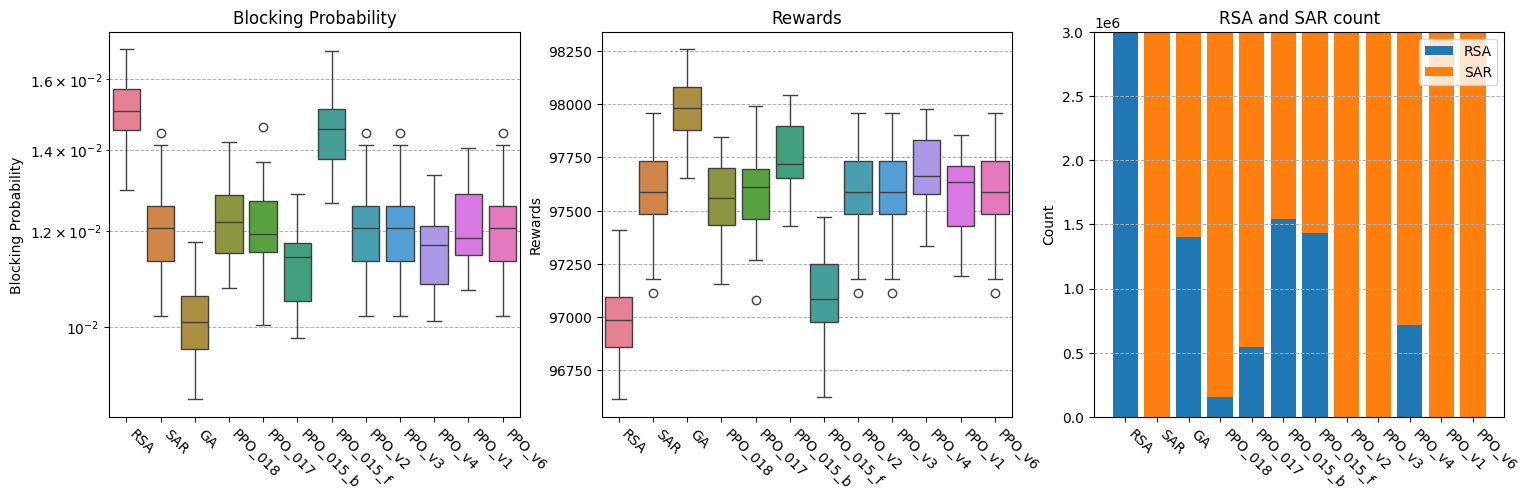

In [41]:
include_models(results_models_300e)

In [23]:
pd.DataFrame(results_models_300e).drop(index="RSA_SAR_count")

,RSA,SAR,GA
pbs,"[0.01455, 0.01504, 0.01585, 0.01582, 0.01466, ...","[0.01223, 0.01234, 0.01261, 0.01237, 0.01223, ...","[0.01004, 0.01001, 0.01103, 0.0101, 0.01062, 0..."
rewards,"[97090.0, 96992.0, 96830.0, 96836.0, 97068.0, ...","[97554.0, 97532.0, 97478.0, 97526.0, 97554.0, ...","[97992.0, 97998.0, 97794.0, 97980.0, 97876.0, ..."


In [29]:
def diff_models(models_results):
    data_name = []
    data_PB = []
    data_rewards = []

    for model_name, model_data in models_results.items():

        data_name.append(model_name)

        data_PB.append(np.array(model_data["pbs"]).mean())

        data_rewards.append(np.array(model_data["rewards"]).mean())

    # Tabela com a diferença percentual entre os modelos usando o SAR como referência
    df = pd.DataFrame({
        "Blocking Probability": data_PB,
        "Rewards": data_rewards
    }, index=data_name)

    #df = df.div(df.loc["SAR"]) - 1

    return df  


diff_models(results_models_300e)

,Blocking Probability,Rewards
RSA,0.015079,96984.200000
SAR,0.012063,97587.400000
GA,0.010086,97982.866667
PPO_018,0.012241,97551.800000
PPO_017,0.012058,97588.466667


# Testando modelos com diferentes configurações

### Modelo 018

Utilizando ODD-one-hot

In [27]:
enviroment_type_models = {
    "Observation": "ODD-one-hot",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_018 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\PPO_018\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_018'] = run_test(env, model_018, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01228 | Reward: 97544.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.013 | Reward: 97400.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01301 | Reward: 97398.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01237 | Reward: 97526.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01266 | Reward: 97468.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01211 | Reward: 97578.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01102 | Reward: 97796.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01076 | Reward: 97848.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01309 | Reward: 97382.0 | Req: 100000
Execut

### Modelo 017

In [28]:
enviroment_type_models = {
    "Observation": "ODD-one-hot",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_017 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\PPO_017\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_017'] = run_test(env, model_017, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01176 | Reward: 97648.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01173 | Reward: 97654.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01274 | Reward: 97452.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01203 | Reward: 97594.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01224 | Reward: 97552.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01248 | Reward: 97504.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01107 | Reward: 97786.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.0108 | Reward: 97840.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01298 | Reward: 97404.0 | Req: 100000
Execu

### Modelo 015

In [31]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_015 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\PPO_015\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_015_b'] = run_test(env, model_015, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01085 | Reward: 97830.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01173 | Reward: 97654.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01189 | Reward: 97622.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01126 | Reward: 97748.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01142 | Reward: 97716.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01067 | Reward: 97866.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01012 | Reward: 97976.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0115 | Reward: 97700.0 | Req: 100000
Execu

In [32]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_015_f = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\PPO_015\\training\\final_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_015_f'] = run_test(env, model_015_f, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01493 | Reward: 97014.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01493 | Reward: 97014.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01579 | Reward: 96842.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01476 | Reward: 97048.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01442 | Reward: 97116.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01456 | Reward: 97088.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01345 | Reward: 97310.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01338 | Reward: 97324.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01528 | Reward: 96944.0 | Req: 100000
Exec

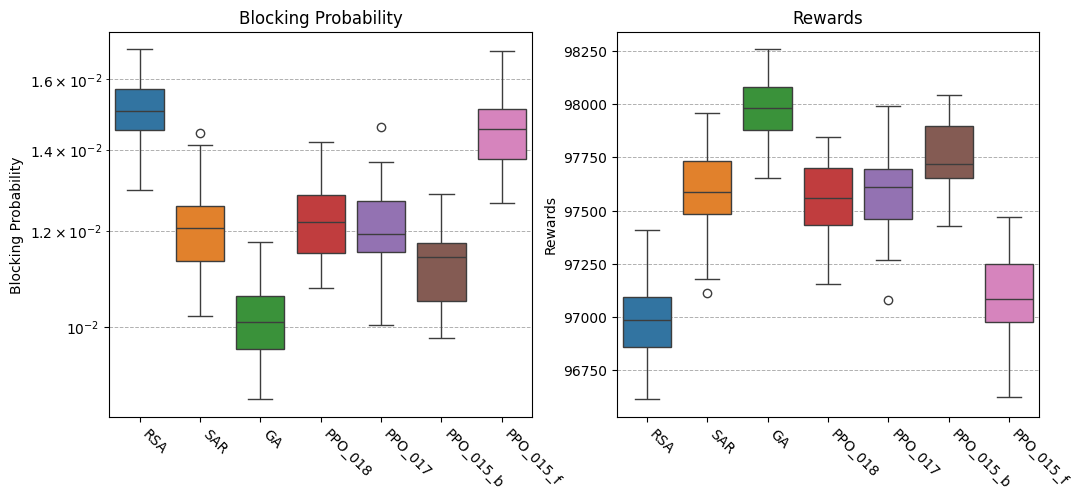

In [33]:
include_models(results_models_300e)

### Modelo 014

In [20]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_014 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\PPO_014\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
M_014_pbs, M_014_rewards = run_test(env, model_014, num_sim=30)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15795.
Blocking Probability: 0.01197 | Reward: 97606.0 | Req: 100000
Executando simulação 2 de 30 com seed 860.
Blocking Probability: 0.01287 | Reward: 97426.0 | Req: 100000
Executando simulação 3 de 30 com seed 76820.
Blocking Probability: 0.01286 | Reward: 97428.0 | Req: 100000
Executando simulação 4 de 30 com seed 54886.
Blocking Probability: 0.01141 | Reward: 97718.0 | Req: 100000
Executando simulação 5 de 30 com seed 6265.
Blocking Probability: 0.0123 | Reward: 97540.0 | Req: 100000
Executando simulação 6 de 30 com seed 82386.
Blocking Probability: 0.01346 | Reward: 97308.0 | Req: 100000
Executando simulação 7 de 30 com seed 37194.
Blocking Probability: 0.01319 | Reward: 97362.0 | Req: 100000
Executando simulação 8 de 30 com seed 87498.
Blocking Probability: 0.01379 | Reward: 97242.0 | Req: 100000
Executando simulação 9 de 30 com seed 44131.
Blocking Probability: 0.01182 | Reward: 97636.0 | Req: 100000
Executan

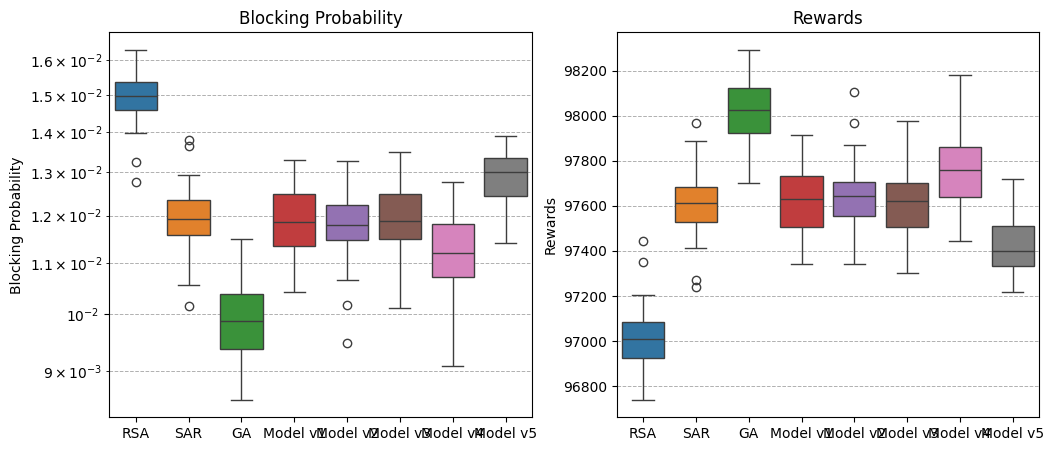

In [21]:
include_models([M_018_pbs, M_017_pbs, M_016_pbs, M_015_pbs, M_014_pbs], [M_018_rewards, M_017_rewards, M_016_rewards, M_015_rewards, M_014_rewards])

### Modelo 004


In [22]:
enviroment_type_models = {
    "Observation": "ODD-one-hot",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_004 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\PPO_004\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
M_004_pbs, M_004_rewards = run_test(env, model_004, num_sim=30)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15795.
Blocking Probability: 0.01107 | Reward: 97786.0 | Req: 100000
Executando simulação 2 de 30 com seed 860.
Blocking Probability: 0.01197 | Reward: 97606.0 | Req: 100000
Executando simulação 3 de 30 com seed 76820.
Blocking Probability: 0.01247 | Reward: 97506.0 | Req: 100000
Executando simulação 4 de 30 com seed 54886.
Blocking Probability: 0.01166 | Reward: 97668.0 | Req: 100000
Executando simulação 5 de 30 com seed 6265.
Blocking Probability: 0.01198 | Reward: 97604.0 | Req: 100000
Executando simulação 6 de 30 com seed 82386.
Blocking Probability: 0.01352 | Reward: 97296.0 | Req: 100000
Executando simulação 7 de 30 com seed 37194.
Blocking Probability: 0.01268 | Reward: 97464.0 | Req: 100000
Executando simulação 8 de 30 com seed 87498.
Blocking Probability: 0.01363 | Reward: 97274.0 | Req: 100000
Executando simulação 9 de 30 com seed 44131.
Blocking Probability: 0.01199 | Reward: 97602.0 | Req: 100000
Executa

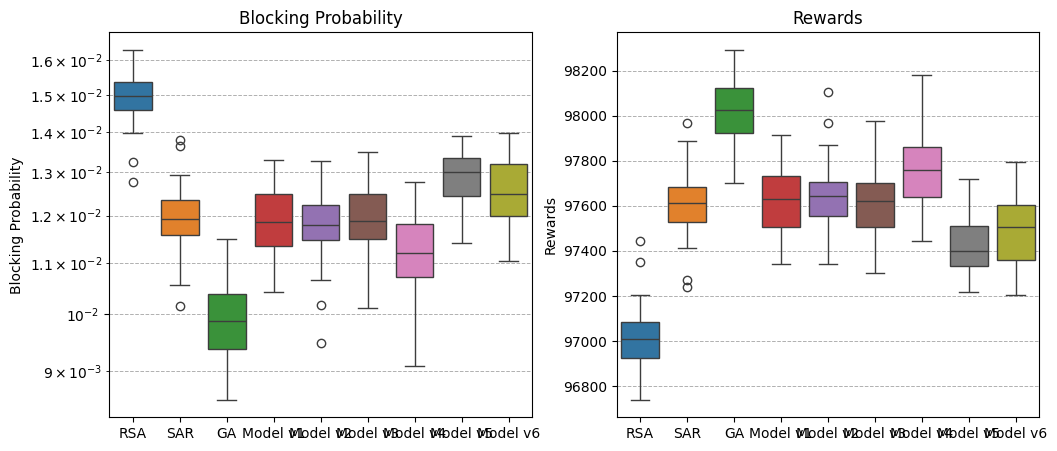

In [23]:
include_models([M_018_pbs, M_017_pbs, M_016_pbs, M_015_pbs, M_014_pbs, M_004_pbs], [M_018_rewards, M_017_rewards, M_016_rewards, M_015_rewards, M_014_rewards, M_004_rewards])

### Modelo 003


In [24]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_003 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\PPO_003\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
M_003_pbs, M_003_rewards = run_test(env, model_003, num_sim=30)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15795.
Blocking Probability: 0.01135 | Reward: 97730.0 | Req: 100000
Executando simulação 2 de 30 com seed 860.
Blocking Probability: 0.01162 | Reward: 97676.0 | Req: 100000
Executando simulação 3 de 30 com seed 76820.
Blocking Probability: 0.01227 | Reward: 97546.0 | Req: 100000
Executando simulação 4 de 30 com seed 54886.
Blocking Probability: 0.01056 | Reward: 97888.0 | Req: 100000
Executando simulação 5 de 30 com seed 6265.
Blocking Probability: 0.01148 | Reward: 97704.0 | Req: 100000
Executando simulação 6 de 30 com seed 82386.
Blocking Probability: 0.01365 | Reward: 97270.0 | Req: 100000
Executando simulação 7 de 30 com seed 37194.
Blocking Probability: 0.01252 | Reward: 97496.0 | Req: 100000
Executando simulação 8 de 30 com seed 87498.
Blocking Probability: 0.01258 | Reward: 97484.0 | Req: 100000
Executando simulação 9 de 30 com seed 44131.
Blocking Probability: 0.01118 | Reward: 97764.0 | Req: 100000
Executa

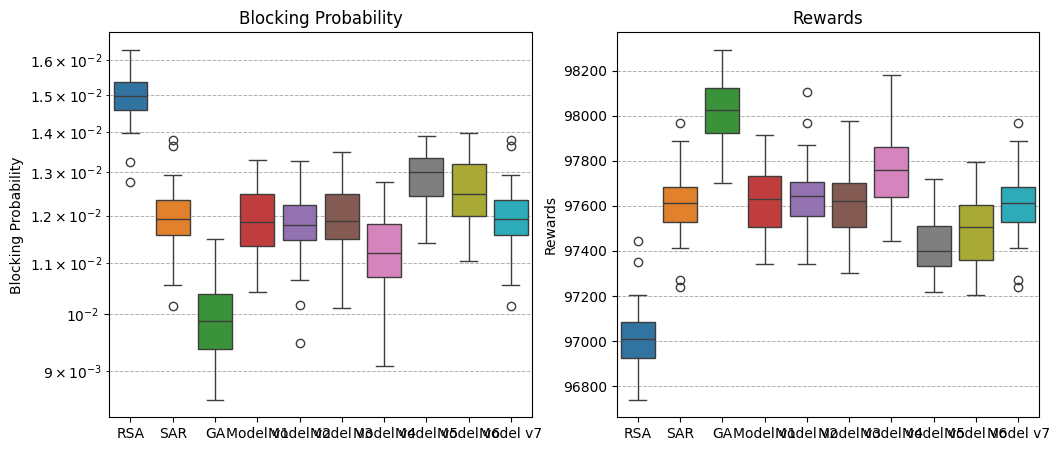

In [25]:
include_models([M_018_pbs, M_017_pbs, M_016_pbs, M_015_pbs, M_014_pbs, M_004_pbs, M_003_pbs], [M_018_rewards, M_017_rewards, M_016_rewards, M_015_rewards, M_014_rewards, M_004_rewards, M_003_rewards])

### Salvando todos os resultados

In [26]:
results = {
    "RSA": {
        "pbs": RSA_pbs,
        "rewards": RSA_rewards
    },
    "SAR": {
        "pbs": SAR_pbs,
        "rewards": SAR_rewards
    },
    "GA": {
        "pbs": GA_pbs,
        "rewards": GA_rewards
    },
    "M_018": {
        "pbs": M_018_pbs,
        "rewards": M_018_rewards
    },
    "M_017": {
        "pbs": M_017_pbs,
        "rewards": M_017_rewards
    },
    "M_016": {
        "pbs": M_016_pbs,
        "rewards": M_016_rewards
    },
    "M_015": {
        "pbs": M_015_pbs,
        "rewards": M_015_rewards
    },
    "M_014": {
        "pbs": M_014_pbs,
        "rewards": M_014_rewards
    },
    "M_004": {
        "pbs": M_004_pbs,
        "rewards": M_004_rewards
    },
    "M_003": {
        "pbs": M_003_pbs,
        "rewards": M_003_rewards
    }
}

import pickle

with open("results_models.pkl", "wb") as f:
    pickle.dump(results, f)

### Modelo 001

In [28]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_001 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\PPO_001\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
M_001_pbs, M_001_rewards = run_test(env, model_001, num_sim=30)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15795.
Blocking Probability: 0.01079 | Reward: 97842.0 | Req: 100000
Executando simulação 2 de 30 com seed 860.
Blocking Probability: 0.01229 | Reward: 97542.0 | Req: 100000
Executando simulação 3 de 30 com seed 76820.
Blocking Probability: 0.01212 | Reward: 97576.0 | Req: 100000
Executando simulação 4 de 30 com seed 54886.
Blocking Probability: 0.0108 | Reward: 97840.0 | Req: 100000
Executando simulação 5 de 30 com seed 6265.
Blocking Probability: 0.01211 | Reward: 97578.0 | Req: 100000
Executando simulação 6 de 30 com seed 82386.
Blocking Probability: 0.01353 | Reward: 97294.0 | Req: 100000
Executando simulação 7 de 30 com seed 37194.
Blocking Probability: 0.01239 | Reward: 97522.0 | Req: 100000
Executando simulação 8 de 30 com seed 87498.
Blocking Probability: 0.01298 | Reward: 97404.0 | Req: 100000
Executando simulação 9 de 30 com seed 44131.
Blocking Probability: 0.01131 | Reward: 97738.0 | Req: 100000
Executan

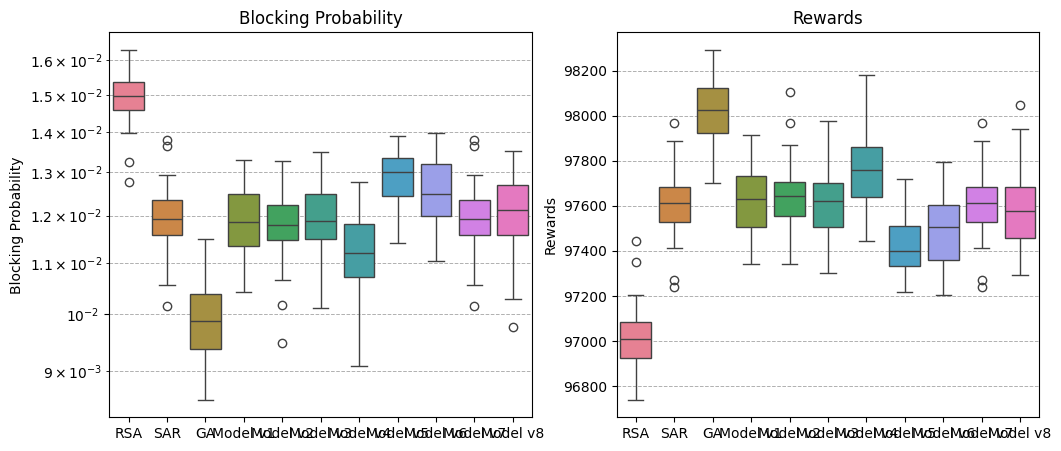

In [29]:
include_models([M_018_pbs, M_017_pbs, M_016_pbs, M_015_pbs, M_014_pbs, M_004_pbs, M_003_pbs, M_001_pbs], [M_018_rewards, M_017_rewards, M_016_rewards, M_015_rewards, M_014_rewards, M_004_rewards, M_003_rewards, M_001_rewards])

### Importando os dados do modelos e plotando os melhores

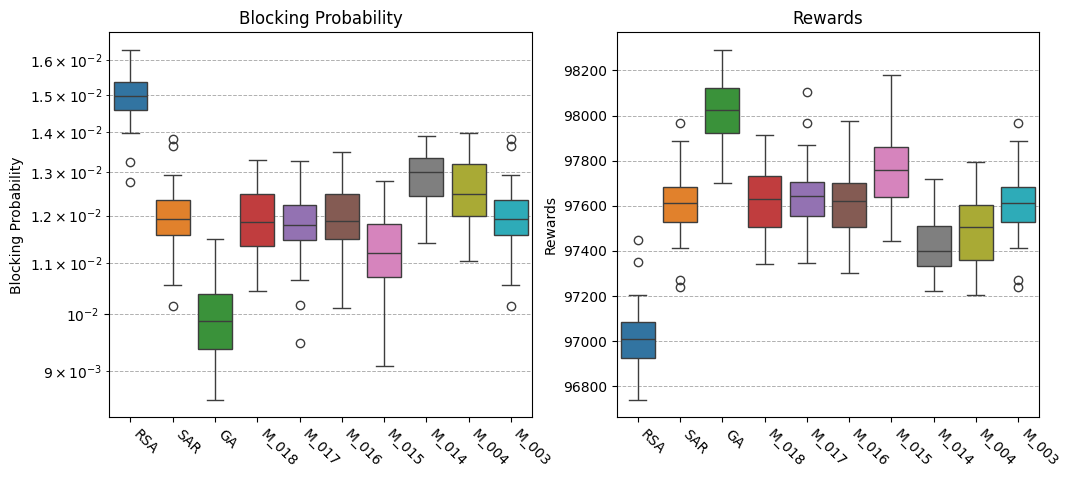

In [23]:
import pickle

with open("results_models.pkl", "rb") as f:
    results = pickle.load(f)

include_models(results)

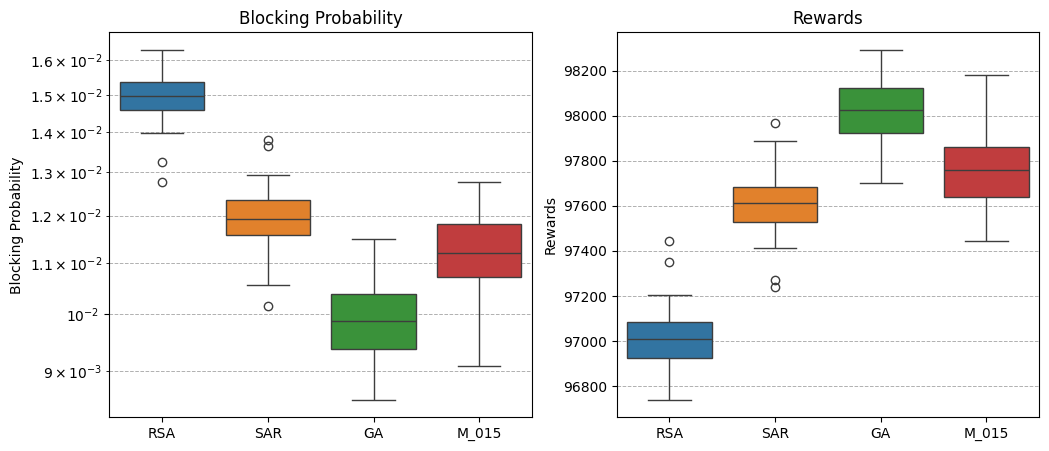

In [25]:
# Cria um dicionário mantendo somente o 'RSA', 'SAR', 'GA' e 'M_015'.
results_2 = {
    "RSA": results["RSA"],
    "SAR": results["SAR"],
    "GA": results["GA"],
    "M_015": results["M_015"]
}

include_models(results_2)

In [ ]:
include_models(results)

# Simulando os 4 novos modelos com 300 Erlangs

## Modelo Versão 2

In [34]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v2 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v1_002\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v2'] = run_test(env, model_v2, num_sim=30, main_seed=123)


Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01261 | Reward: 97478.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01237 | Reward: 97526.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01083 | Reward: 97834.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01093 | Reward: 97814.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0126 | Reward: 97480.0 | Req: 100000
Execu

## Modelo Versão 3

In [35]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v3 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v3_001\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v3'] = run_test(env, model_v3, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01261 | Reward: 97478.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01237 | Reward: 97526.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01083 | Reward: 97834.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01093 | Reward: 97814.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0126 | Reward: 97480.0 | Req: 100000
Execu

## Modelo Versão 4

In [36]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v4 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v4_001\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v4'] = run_test(env, model_v4, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01121 | Reward: 97758.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01179 | Reward: 97642.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01225 | Reward: 97550.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01247 | Reward: 97506.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01149 | Reward: 97702.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01104 | Reward: 97792.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01042 | Reward: 97916.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01034 | Reward: 97932.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01297 | Reward: 97406.0 | Req: 100000
Exec

## Modelo Versão 1

In [37]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v1 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v1_001\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v1'] = run_test(env, model_v1, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01327 | Reward: 97346.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01164 | Reward: 97672.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01221 | Reward: 97558.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01192 | Reward: 97616.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01158 | Reward: 97684.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01188 | Reward: 97624.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01178 | Reward: 97644.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01077 | Reward: 97846.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01287 | Reward: 97426.0 | Req: 100000
Exec

## Modelo V6

In [38]:
enviroment_type_models = {
    "Observation": "ODD-one-hot",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v6 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v6_001\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v6'] = run_test(env, model_v6, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01261 | Reward: 97478.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01237 | Reward: 97526.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01083 | Reward: 97834.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01093 | Reward: 97814.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0126 | Reward: 97480.0 | Req: 100000
Execu

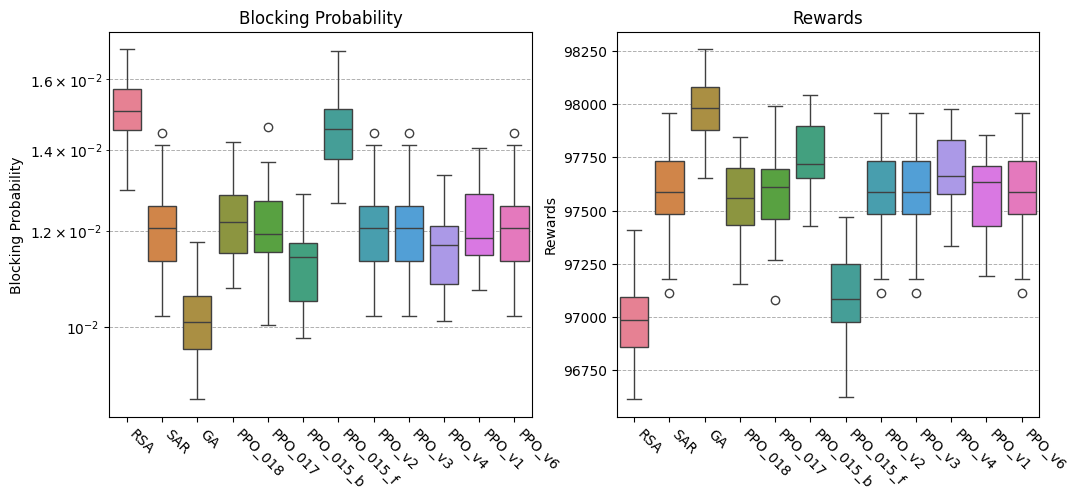

In [39]:
include_models(results_models_300e)

## Modelo V7

In [43]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v7 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v7_001\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v7'] = run_test(env, model_v7, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01261 | Reward: 97478.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01237 | Reward: 97526.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01083 | Reward: 97834.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01093 | Reward: 97814.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0126 | Reward: 97480.0 | Req: 100000
Execu

## Modelo V8

In [44]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v8 = PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v8_001\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v8'] = run_test(env, model_v8, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01199 | Reward: 97602.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01216 | Reward: 97568.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01364 | Reward: 97272.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01209 | Reward: 97582.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01196 | Reward: 97608.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01227 | Reward: 97546.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01173 | Reward: 97654.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01146 | Reward: 97708.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01374 | Reward: 97252.0 | Req: 100000
Exec

## Modelo V9

In [47]:
# Import A2C
from stable_baselines3 import A2C


enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v9 = A2C.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v8_002\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v9'] = run_test(env, model_v9, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01261 | Reward: 97478.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01237 | Reward: 97526.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01083 | Reward: 97834.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01093 | Reward: 97814.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0126 | Reward: 97480.0 | Req: 100000
Execu

## Modelo V10

In [48]:
# Importando o DQN
from stable_baselines3 import DQN

enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v10 = DQN.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v10_004\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v10'] = run_test(env, model_v10, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01261 | Reward: 97478.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01237 | Reward: 97526.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01083 | Reward: 97834.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01093 | Reward: 97814.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0126 | Reward: 97480.0 | Req: 100000
Execu

## Gráfico

C:\Users\mathe\AppData\Local\Temp\ipykernel_8112\436873453.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')


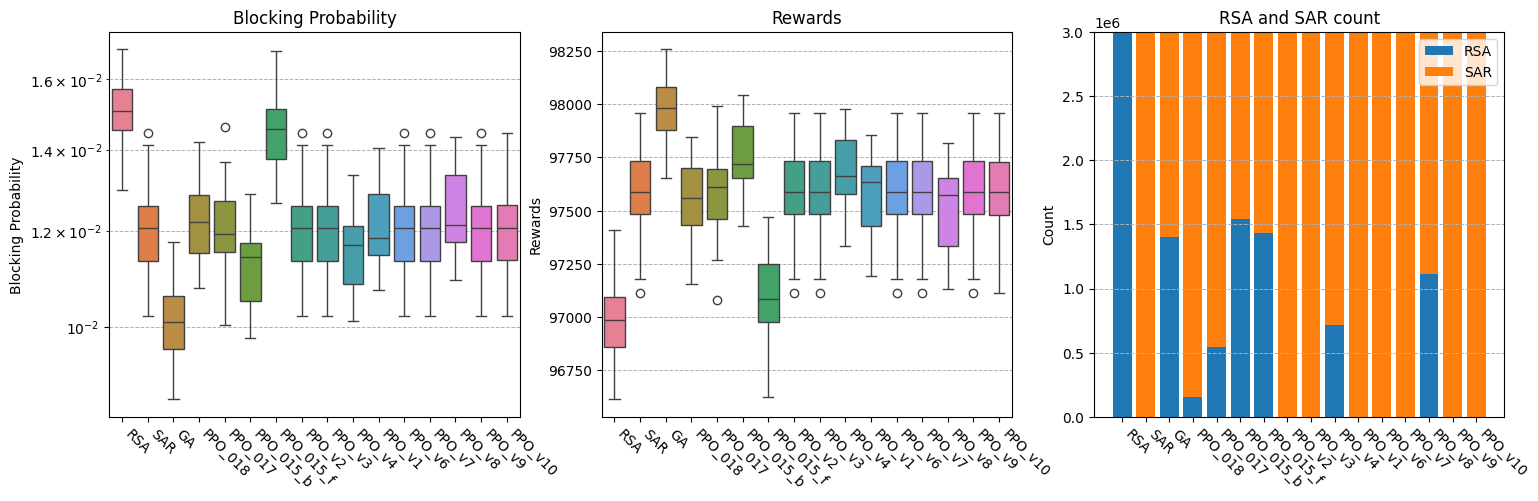

In [49]:
include_models(results_models_300e)

In [50]:
# Salvando o dicionário com os resultados
with open("results_models_300e.pkl", "wb") as f:
    pickle.dump(results_models_300e, f)

# More Models

In [16]:
# Importando os modelos treinados

import pickle

with open("results_models_300e.pkl", "rb") as f:
    results_models_300e = pickle.load(f)

EOFError: Ran out of input

## Modelo V11

In [20]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v11 =PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v11_001\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v11_max'] = run_test(env, model_v11, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01103 | Reward: 97794.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01134 | Reward: 97732.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01179 | Reward: 97642.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01117 | Reward: 97766.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01121 | Reward: 97758.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01085 | Reward: 97830.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01024 | Reward: 97952.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.00961 | Reward: 98078.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01173 | Reward: 97654.0 | Req: 100000
Exec

In [30]:
results_models = {
    
}

In [31]:
results_models['RSA'] = results_models_300e['RSA']
results_models['SAR'] = results_models_300e['SAR']
results_models['GA'] = results_models_300e['GA']
results_models['PPO_015_b'] = results_models_300e['PPO_015_b']
results_models['PPO_v4'] = results_models_300e['PPO_v4']
#results_models['PPO_v11'] = results_models_300e['PPO_v11']
results_models['PPO_v11_max'] = results_models_300e['PPO_v11_max']


C:\Users\mathe\AppData\Local\Temp\ipykernel_39572\436873453.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')


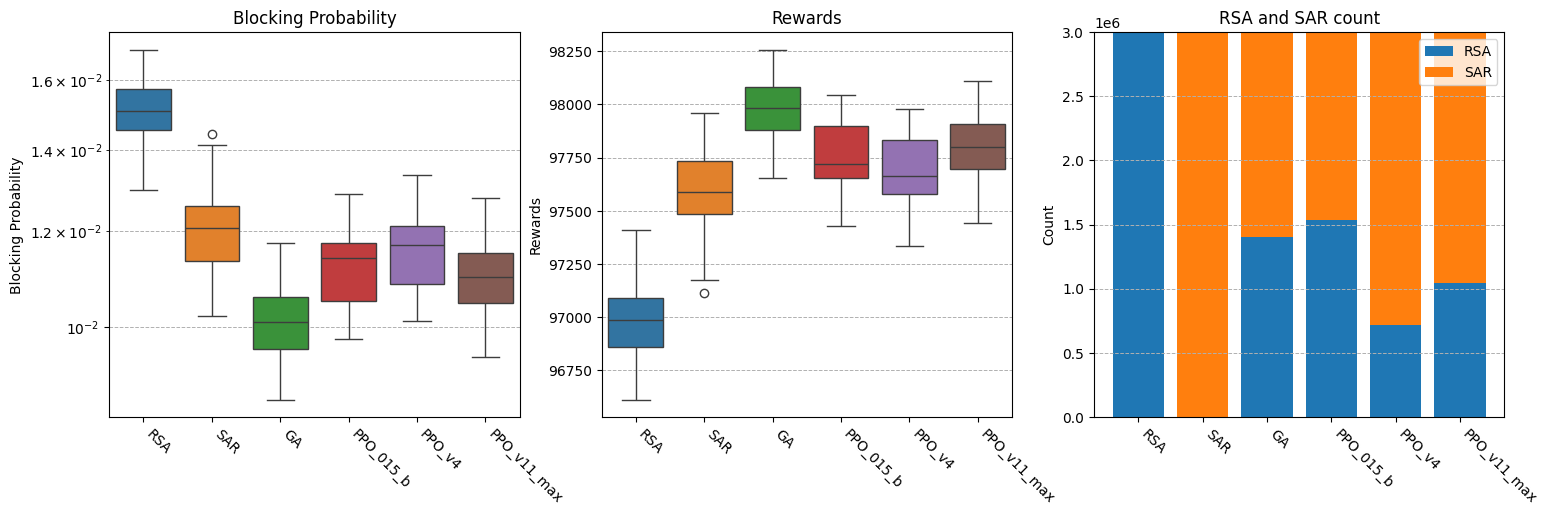

In [32]:
include_models(results_models)

# Modelo V12

In [33]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v12 =PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v12_001\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v12'] = run_test(env, model_v12, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01261 | Reward: 97478.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01237 | Reward: 97526.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01083 | Reward: 97834.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01093 | Reward: 97814.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0126 | Reward: 97480.0 | Req: 100000
Execu

C:\Users\mathe\AppData\Local\Temp\ipykernel_39572\436873453.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')


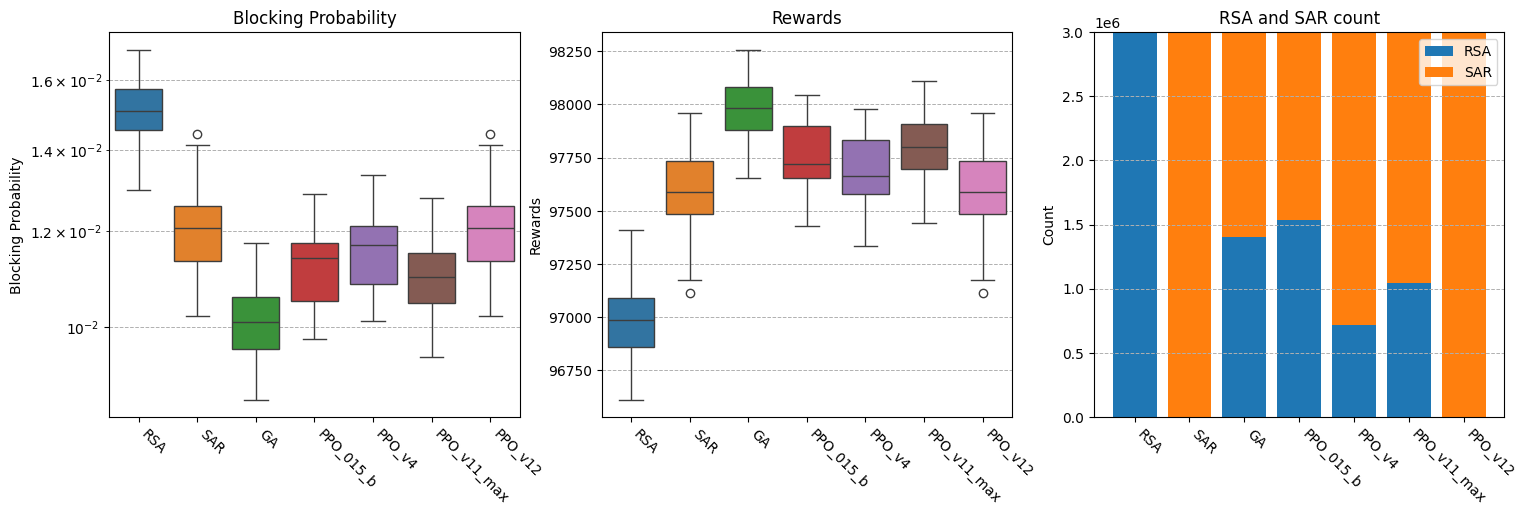

In [34]:
results_models['PPO_v12'] = results_models_300e['PPO_v12']

include_models(results_models)

# Modelo V13

In [35]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v13 =PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v13_006\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v13'] = run_test(env, model_v13, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01161 | Reward: 97678.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01202 | Reward: 97596.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01307 | Reward: 97386.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01268 | Reward: 97464.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01147 | Reward: 97706.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.0113 | Reward: 97740.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01136 | Reward: 97728.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01035 | Reward: 97930.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01303 | Reward: 97394.0 | Req: 100000
Execu

## Modelo V14

In [36]:
enviroment_type_models = {
    "Observation": "ODD-one-hot",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v14 =PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v14_002\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v14'] = run_test(env, model_v14, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.0122 | Reward: 97560.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01279 | Reward: 97442.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01395 | Reward: 97210.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01251 | Reward: 97498.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01273 | Reward: 97454.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.0133 | Reward: 97340.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01231 | Reward: 97538.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01154 | Reward: 97692.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01325 | Reward: 97350.0 | Req: 100000
Execut

C:\Users\mathe\AppData\Local\Temp\ipykernel_39572\436873453.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')


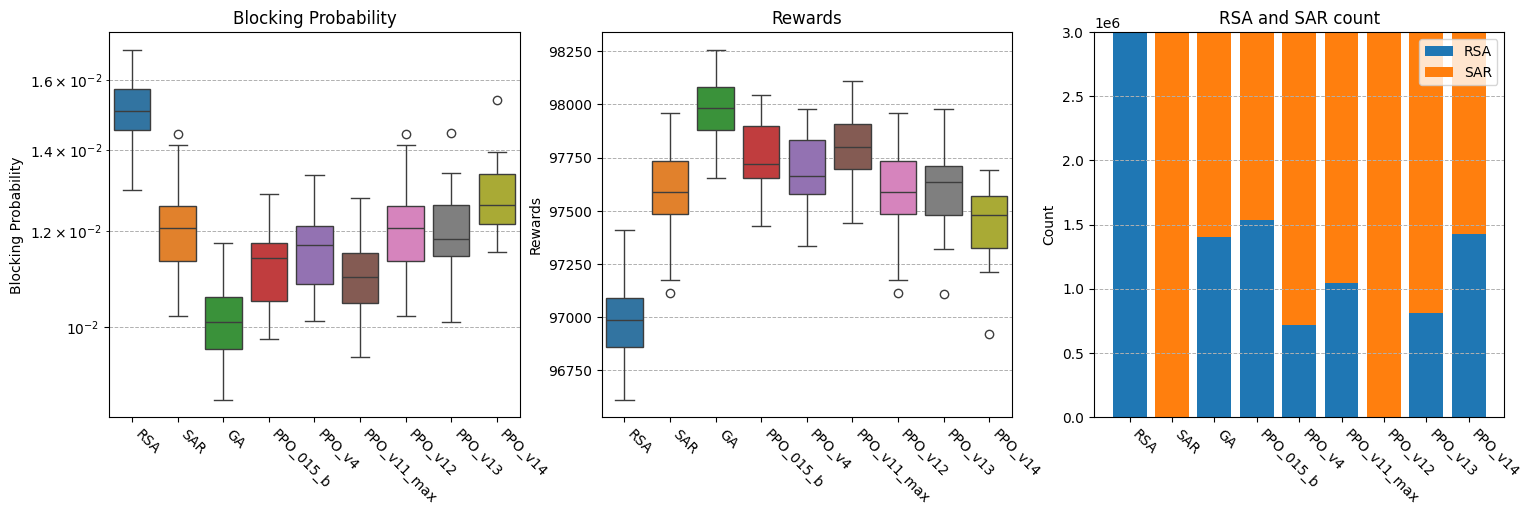

In [37]:
results_models['PPO_v13'] = results_models_300e['PPO_v13']
results_models['PPO_v14'] = results_models_300e['PPO_v14']

include_models(results_models)

## modelo V15

In [38]:
enviroment_type_models = {
    "Observation": "ODD-one-hot",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v15 =PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v15_010\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v15'] = run_test(env, model_v15, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01216 | Reward: 97568.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01247 | Reward: 97506.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01302 | Reward: 97396.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01283 | Reward: 97434.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01197 | Reward: 97606.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01225 | Reward: 97550.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01093 | Reward: 97814.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01102 | Reward: 97796.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01278 | Reward: 97444.0 | Req: 100000
Exec

C:\Users\mathe\AppData\Local\Temp\ipykernel_39572\436873453.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')


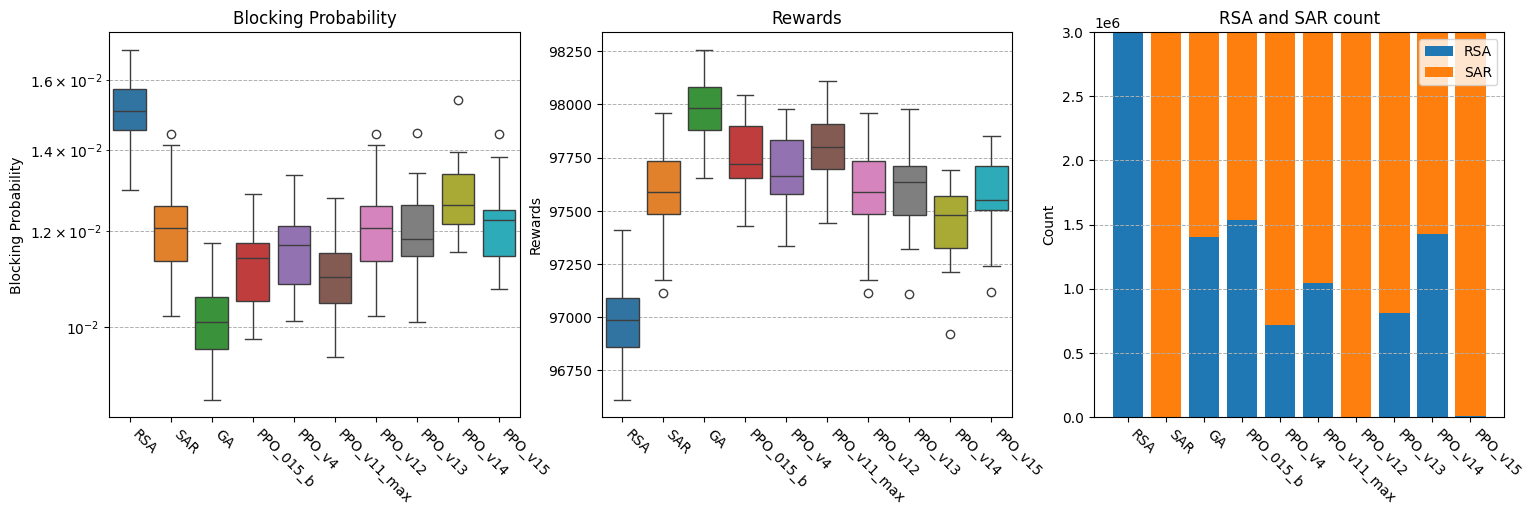

In [39]:
results_models['PPO_v15'] = results_models_300e['PPO_v15']

include_models(results_models)

## Modelo V16

In [40]:
enviroment_type_models = {
    "Observation": "ODD-one-hot+actions",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v16 =PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v16_003\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v16'] = run_test(env, model_v16, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01261 | Reward: 97478.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01237 | Reward: 97526.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01083 | Reward: 97834.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01093 | Reward: 97814.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0126 | Reward: 97480.0 | Req: 100000
Execu

## Modelo V19

In [42]:
enviroment_type_models = {
    "Observation": "ODD-one-hot",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v19 =PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v19_001\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v19'] = run_test(env, model_v19, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01261 | Reward: 97478.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01237 | Reward: 97526.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01223 | Reward: 97554.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01234 | Reward: 97532.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01083 | Reward: 97834.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01093 | Reward: 97814.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.0126 | Reward: 97480.0 | Req: 100000
Execu

## Modelo V21

In [43]:
enviroment_type_models = {
    "Observation": "availability-vector",
    "Action": "RSA-SAR",
    "Reward": "RL-defaut",
    "StopCond": "MaxReq",
    "StartCond": "Empty"
}

# Cria o ambiente de simulação
env = Enviroment(
    network_load=300,
    k_routes=K_ROUTES,
    number_of_slots=NUMBER_OF_SLOTS,
    enviroment_type=enviroment_type_models,
    data_folder="PPO_Eval",
)

model_v21 =PPO.load("D:\\98_phD_Files\\Projeto 006 - Artigo rede regular iTwo\\logs\\Train_PPO_40kReqs_300_v21_001\\training\\best_model\\best_model.zip", env=env)

## Retorna a PB para o modelo treinado
results_models_300e['PPO_v21'] = run_test(env, model_v21, num_sim=30, main_seed=123)

Executando a avaliação do modelo
Executando simulação 1 de 30 com seed 15725.
Blocking Probability: 0.01385 | Reward: 97230.0 | Req: 100000
Executando simulação 2 de 30 com seed 28030.
Blocking Probability: 0.01343 | Reward: 97314.0 | Req: 100000
Executando simulação 3 de 30 com seed 17730.
Blocking Probability: 0.01429 | Reward: 97142.0 | Req: 100000
Executando simulação 4 de 30 com seed 61404.
Blocking Probability: 0.01369 | Reward: 97262.0 | Req: 100000
Executando simulação 5 de 30 com seed 63206.
Blocking Probability: 0.01329 | Reward: 97342.0 | Req: 100000
Executando simulação 6 de 30 com seed 15377.
Blocking Probability: 0.01376 | Reward: 97248.0 | Req: 100000
Executando simulação 7 de 30 com seed 73299.
Blocking Probability: 0.01319 | Reward: 97362.0 | Req: 100000
Executando simulação 8 de 30 com seed 46203.
Blocking Probability: 0.01162 | Reward: 97676.0 | Req: 100000
Executando simulação 9 de 30 com seed 89302.
Blocking Probability: 0.01448 | Reward: 97104.0 | Req: 100000
Exec

C:\Users\mathe\AppData\Local\Temp\ipykernel_39572\436873453.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')


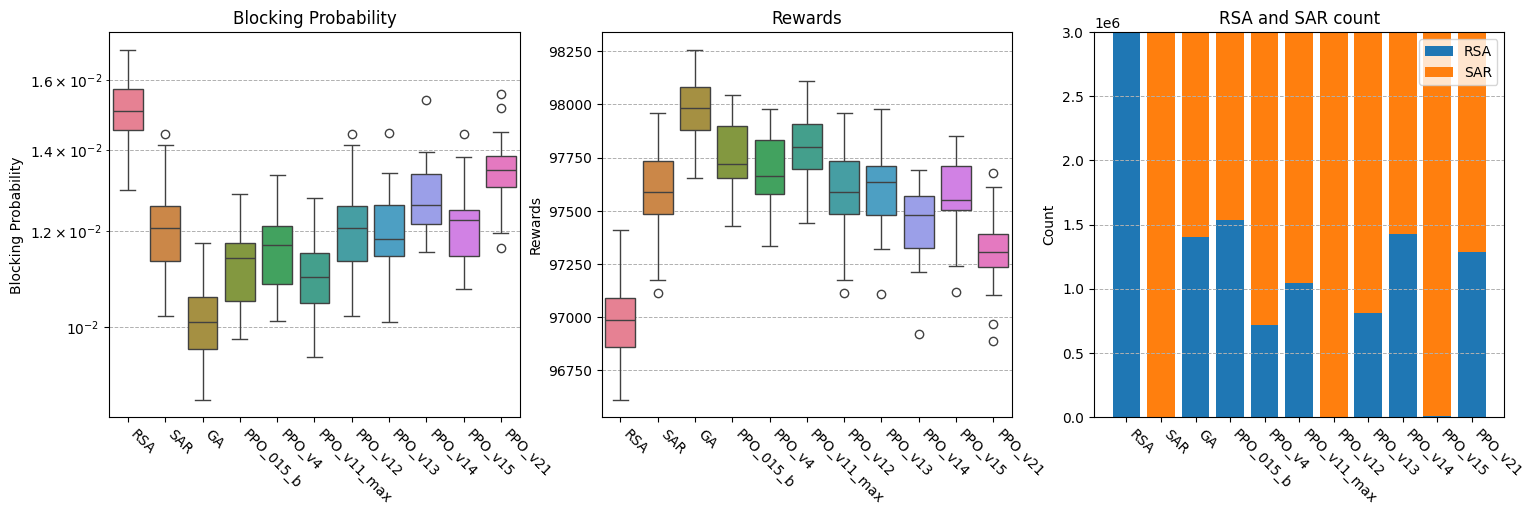

In [44]:
results_models['PPO_v21'] = results_models_300e['PPO_v21']

include_models(results_models)

# Novas simulações